TAREA: Captura una o varias imágenes con monedas no solapadas. Tras visualizar la imagen, identifica de forma interactiva (por ejemplo haciendo clic en la imagen) una moneda de un valor determinado en la imagen (por ejemplo de 1€). Tras ello, la tarea se resuelve mostrando por pantalla el número de monedas y la cantidad de dinero presentes en la imagen. No hay restricciones sobre utilizar medidas geométricas o de color. ¿Qué problemas han observado?

Nota: Para establecer la correspondencia entre píxeles y milímetros, comentar que la moneda de un euro tiene un diámetro de 23.25 mm. la de 50 céntimos de 24.35, la de 20 céntimos de 22.25, etc. 

Extras: Considerar que la imagen pueda contener objetos que no son monedas y/o haya solape entre las monedas. Demo en vivo.



El mundo real es muy variado, las imágenes no siempre se capturan con unas condiciones de iluminación tan buenas o controladas. Ejemplo con aplicación de variantes de umbralizados ofrecidas por OpenCV.

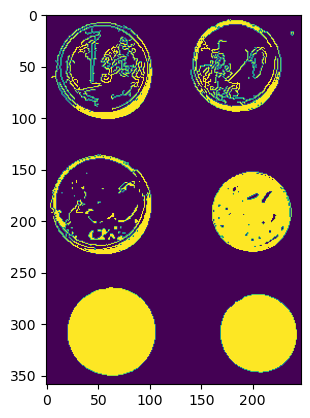

In [1]:
import cv2  
import numpy as np
import matplotlib.pyplot as plt
import math

img = cv2.imread('Monedas_1.jpg') 

img = cv2.resize(img, (0,0), fx=0.2, fy=0.2)  #Para imagenes grandes

def showHist(imagen):
    #Cálculo del histograma con 256 bins de una imagen en escala de grises
    hist = cv2.calcHist([imagen], [0], None, [256], [0, 256])

    plt.figure()
    plt.subplot(1, 2, 1)
    plt.axis("off")
    plt.imshow(img_gris, cmap='gray')

    # Histograma sin normalizar
    plt.subplot(1, 2, 2)
    plt.title("Histograma")
    plt.xlabel("Bins")
    plt.ylabel("# píxeles")
    plt.plot(hist)
    plt.xlim([0, 256])
    # Separo subplots horizontalmente
    plt.subplots_adjust(wspace=0.4)

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img_gris = cv2.GaussianBlur(img_gris,(5,5),0)

t_lower = 30  # Lower Threshold 
t_upper = 150  # Upper threshold 
  
# Applying the Canny Edge filter 
edge = cv2.Canny(img_gris, t_lower, t_upper) 

img_sub_edge = cv2.subtract(img_gris, edge)

th2,img_th2 = cv2.threshold(img_sub_edge,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

plt.imshow(img_th2)

font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 0.5
thickness = 2

CoinList = []


def getDistance(obj1, obj2):
    xDif = obj2[0] - obj1[0]
    yDif = obj2[1] - obj1[1]
    return math.sqrt( xDif*xDif + yDif*yDif)

def Guess_coin(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img_rgb,(x,y),5,(20,100,200),-1)
        mouseX,mouseY = x,y
        monedaEuro = Coin((0,0),0)
        for c in CoinList:
            distance = abs(getDistance((c.center), (x,y)))
            if distance <= c.radio:
                monedaEuro = c
                break
            
        ratio = monedaEuro.radio*2 / StandarCoinMetrics[6][2]

        for c in CoinList:
            diametro = c.radio*2
            bestRatio = 0
            bestCoin = ""
            for s in StandarCoinMetrics:
                actualRatio = c.radio*2 / s[2]

                if (abs(actualRatio - ratio) < abs(bestRatio - ratio)):
                    bestRatio = actualRatio
                    bestCoin = s[1]

            cv2.circle(img_rgb, c.center, 3, (20,90,20), -1)
            cv2.putText(img_rgb, bestCoin, (c.center[0] - 10, c.center[1]-5), font, font_scale, (255, 255, 255), thickness)
            

cv2.namedWindow('ImagenMonedas')
cv2.setMouseCallback('ImagenMonedas',Guess_coin)

StandarCoinMetrics = [(1,"1 centimo",16.26),
                      (2,"2 centimos",18.75),
                      (5,"5 centimos", 21.25),
                      (10,"10 centimos", 19.75),
                      (20,"20 centimos", 22.25),
                      (50,"50 centimos", 24.25),
                      (100,"1 euro", 23.25),
                      (200,"2 euros", 25.75)]

class Coin():

    def __init__(self,center,radio):
        self.center = center
        self.radio = radio


contoursCoins, hierarchyMonedas = cv2.findContours(img_th2, 
    cv2.RETR_EXTERNAL , 
    cv2.CHAIN_APPROX_SIMPLE)

cv2.drawContours(img_rgb, contoursCoins, -1, (0,0,255), 3)

minArea = 500

rectangulos = []

for contorno in contoursCoins:
    x, y, w, h = cv2.boundingRect(contorno)
    area = w * h
    if area < minArea:
        continue
    rectangulos.append((x, y, w, h, area))

def esta_dentro(rect1, rect2):
    x1, y1, w1, h1, _ = rect1
    x2, y2, w2, h2, _ = rect2
    return x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2)

contornos_grandes = []

for i in range(len(rectangulos)):
    es_interno = False
    for j in range(len(rectangulos)):
        if i != j and esta_dentro(rectangulos[i], rectangulos[j]):
            es_interno = True
            break
    if not es_interno:
        contornos_grandes.append(rectangulos[i])

for rect in contornos_grandes:
    x, y, w, h, _ = rect
    cv2.rectangle(img_rgb, (x,y), (x+w, y+h), (0,0,255), 2)
    CoinList.append(Coin((int(x+w/2),int(y+h/2)),w/2))
    img_rgb = cv2.circle(img_rgb, (int(x+w/2),int(y+h/2)), radius=5, color=(0, 255, 0), thickness=-1)


while(True):
    cv2.imshow("ImagenMonedas",img_rgb) 
    # Detenemos pulsado ESC
    if cv2.waitKey(20) == 27:
        break
cv2.destroyAllWindows()

TAREA: Las tres imágenes cargadas en la celda inicial, han sido extraidas de las imágenes de mayor tamaño presentes en la carpeta. La tarea consiste en extraer características (geométricas y/o visuales) e identificar patrones que permitan distinguir las partículas de cada una de las tres clases, evaluando los aciertos y fallos con las imágenes completas considerando las métricas mostradas y la matriz de confusión. La matriz de confusión, muestra para cada clase el número de muestras que se clasifican correctamente de dicha clase, y el número de muestras que se clasifican incorrectamente por cada una de las otras dos clases.

En el trabajo [SMACC: A System for Microplastics Automatic Counting and Classification](https://doi.org/10.1109/ACCESS.2020.2970498), las características geométricas utilizadas fueron:

- Área en píxeles
- Perímetro en píxeles
- Compacidad (relación entre el cuadrado del perímetro y el área de la partícula)
- Relación del área de la partícula con la del contenedor
- Relación del ancho y el alto del contenedor
- Relación entre los ejes de la elipse ajustada
- Definido el centroide, relación entre las distancias menor y mayor al contorno

Si no se quedan satisfechos con la segmentación obtenida, es el mundo real, también en el README comento técnicas recientes de segmentación, que podrían despertar su curiosidad.

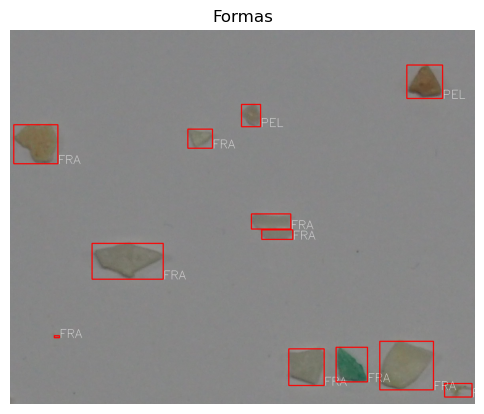

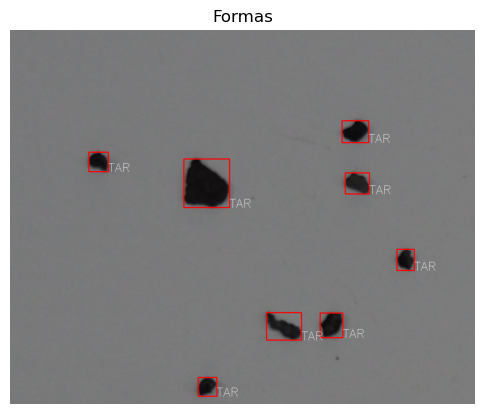

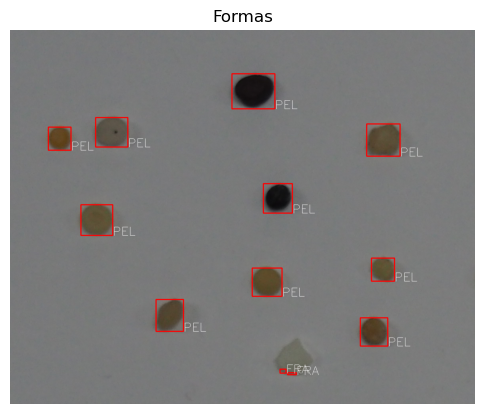

Accuracy (TP/(n))= 0.875
Precision (TP/(TP+FP)) = 0.875
Recall (TP/(TP+FN)) = 0.875
F1 Score (2*(precision*recall)/(precision+recall)) = 0.875


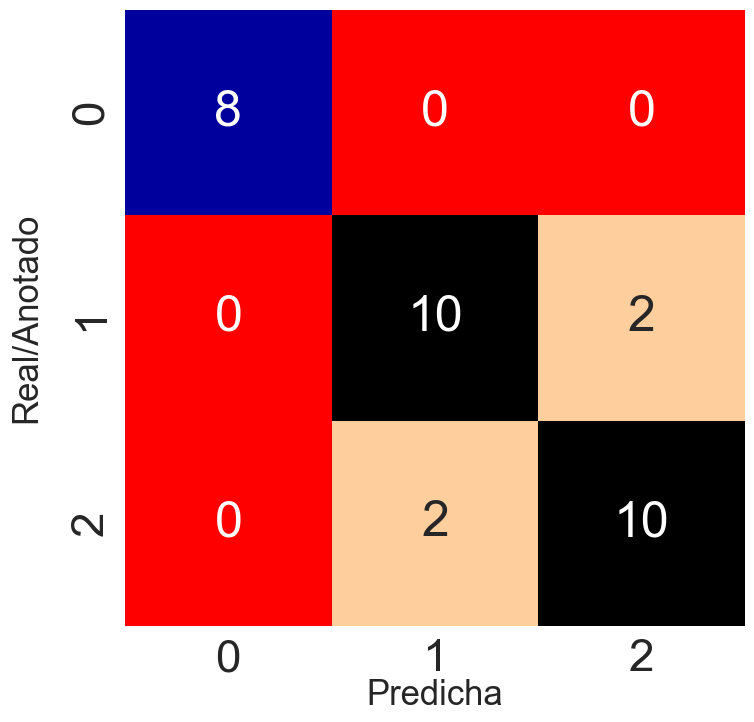

In [2]:
import cv2  
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Cargamos las imágenes
imgF = cv2.imread('FRA.png') 
imgP = cv2.imread('PEL.png')
imgT = cv2.imread('TAR.png')
imgMP = cv2.imread('MPs.jpg')

# Parámeros texto
font = cv2.FONT_HERSHEY_SIMPLEX
font_scale = 1
thickness = 1
black_min = 120
circularidad_min = 17

rect_grandes = []
minArea = 50

tipos = ["TAR", "PEL", "FRA"]

def clasificar(valores):
    color, circularidad = valores

    if (sum(color) < black_min):
        return 0

    if (circularidad < circularidad_min):
        return 1
    return 2    


def esta_dentro(rect1, rect2):
    x1, y1, w1, h1, _, _ = rect1
    x2, y2, w2, h2, _, _ = rect2
    return x1 >= x2 and y1 >= y2 and (x1 + w1) <= (x2 + w2) and (y1 + h1) <= (y2 + h2)

def RemoveInnerContours(contours):
    rectangulos = []

    for contorno in contours:
        x, y, w, h = cv2.boundingRect(contorno)
        area = w * h
        if area < minArea:
            continue
        rectangulos.append((x, y, w, h, area, contorno))

    for i in range(len(rectangulos)):
        es_interno = False
        for j in range(len(rectangulos)):
            if i != j and esta_dentro(rectangulos[i], rectangulos[j]):
                es_interno = True
                break
        if not es_interno:
            rect_grandes.append(rectangulos[i])


def ObtainData(img):
    img_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_gas = cv2.GaussianBlur(img_gris,(5,5),0)

    thotsu,img_thres = cv2.threshold(img_gas,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    DataContour, _ = cv2.findContours(img_thres, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    RemoveInnerContours(DataContour)

    DataContour = [rec[5] for rec in rect_grandes]

    result = list()
    maskImg = np.zeros(img.shape[:2],dtype=np.uint8)

    for c in DataContour:
        # Puntos del contorno
        clon = len(c)
        # Color extraction
        cv2.drawContours(maskImg, [c], -1, 255, thickness=cv2.FILLED)
        
        meanValue = cv2.mean(img,mask=maskImg)
        colorMean = meanValue[:3]
        # Área y perímetro
        area = cv2.contourArea(c)
        perimetro = cv2.arcLength(c, True)

        #Contenedor alineado con ejes de la imagen
        x,y,w,h = cv2.boundingRect(c)
        cv2.rectangle(img, (x,y), (x+w, y+h), (0,0,255), 2)

        # Compactness: 4*pi*Area/Perimeter^2
        if perimetro > 0 and area > 0:
            compacidad = (perimetro ** 2) / area
        else:
            compacidad = 0
        
        # Ajusta elipse si hay suficientes puntos
        if clon >= 5:
            elipse = cv2.fitEllipse(c)
            (center, axes, orientation) = elipse
            major_axis = max(axes)
            minor_axis = min(axes)
            if minor_axis > 0 :
                elipse_ratio = major_axis / minor_axis
            else:
                elipse_ratio = None
        else:
            elipse_ratio = None
        clas = clasificar((colorMean, compacidad))    
        result.append(clas)
        cv2.putText(img, str(tipos[clas]), (x+w, y+h), font, font_scale, (255, 255, 255), thickness)
        
    # Visualiza la imagen
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Formas")
    plt.axis('off')
    plt.show()    
    return result    
    

def calcularMatrizDeConfusion(valores):
    frag, tar, pel = valores
    realNumFrag = 12
    realNumTar = 8
    realNumPel = 12
    
    realData = ([0] * realNumTar) + ([1] * realNumPel) + ([2] * realNumFrag)

    predData = tar + pel + frag

    y = realData

    y_pred = predData

    #Cálculo de métricas
    accuracy = accuracy_score(y, y_pred)
    #Para más de una clase se define la forma de promediar
    precision = precision_score(y, y_pred,average='weighted')
    recall = recall_score(y, y_pred,average='weighted')
    f1score = f1_score(y, y_pred,average='weighted')

    print(f"Accuracy (TP/(n))= {accuracy}")
    print(f"Precision (TP/(TP+FP)) = {precision}")
    print(f"Recall (TP/(TP+FN)) = {recall}")
    print(f"F1 Score (2*(precision*recall)/(precision+recall)) = {f1score}")


    conf_matrix = confusion_matrix(y, y_pred)

    plt.figure(figsize=(8,8))
    sns.set(font_scale = 1.75)#tamaños tipografía
    sns.set(font_scale = 3.0)

    ax = sns.heatmap(
            conf_matrix, # confusion matrix 2D array 
            annot=True, # Muestra números en las celdas
            fmt='d', # valores enteros
            cbar=False, # sin barra de colores
            cmap='flag', # mapa de colores
            #vmax=175 # contraste de color
        )

    #Etiquetas matriz de confusión
    label_font = {'size':'25'}
    ax.set_xlabel("Predicha", labelpad=-0.75, fontdict=label_font)
    ax.set_ylabel("Real/Anotado", labelpad=20, fontdict=label_font)
    

dataF = ObtainData(imgF)
rect_grandes = []
dataT = ObtainData(imgT)
rect_grandes = []
dataP = ObtainData(imgP)
rect_grandes = []

calcularMatrizDeConfusion((dataF, dataT, dataP))

